## Relevant imports

In [51]:
import numpy as np
import simtk.openmm as mm
import simtk.openmm.app as app
from simtk.openmm import unit
from simtk.openmm.openmm import NonbondedForce
import os
import matplotlib.pyplot as plt
from openmmtools.testsystems import AlanineDipeptideExplicit
import sys
import mdtraj as md

## Relevant functions

### Stetic functions

In [52]:
def percentageString(progress, total, divisions):
    length=total/divisions
    stage=int(progress//length)
    token=">"
    if progress==total:
        token="X"
    return "["+"="*stage+token+" "*(divisions-stage)+"]"

### Functions to represent topology

In [53]:
def deleteElements(l, indexList):
    #Deletes all the indexed elements in :indexList: of the list :l:
    indexList.sort()
    count=0
    for index in indexList:
        l.pop(index-count)
        count+=1
    return
def checkBondString(bond, string):
    #Boolean funciton that checks wether an atom with that name is in the bond
    return (bond[0].name==string or bond[1].name==string)
def checkBondAtom(bond, atom):
    #Boolean function that checks wether that particular atom is in the bond
    return (bond[0]==atom or bond[1]==atom)
def getAtomBond(bond, string):
    #Function that returns the atom with the name :string: if it is in :bond:
    #If not it returns an error
    #:bond: must be a two atom bond
    #:string: is the name of the atom
    if checkBondString(bond, string):
        if bond[0].name==string:
            return bond[0]
        else:
            return bond[1]
    print(f'\nERROR getAtomBond({bond}, {string}) there is no {string} in this bond!')
    return None
def getOtherAtom(bond, atom):
    #Function that gets the other atom in a bond pair
    if checkBondAtom(bond, atom):
        if bond[0]==atom:
            return bond[1]
        else:
            return bond[0]
    else:
        print(f'\nERROR getAtomBond({bond}, {string}) there is no {string} in this bond!')
        return None
def findNextBond(pbonds, atom):
    #This function assumes that there is only one next bond per atom
    prunelist=[]           #list of bonds that will be pruned  
    possibleBonds=['CA', 'N', 'C', 'CH'] #List of possible nextbonds
    nextAtom=atom
    index=0
    for bond in pbonds:
        #We want to check the bonds with the main atom
        #If we find a suitable bond then the bonded atom will be the next atom
        if checkBondAtom(bond, atom):
            if getOtherAtom(bond, atom).name in possibleBonds:
                nextAtom=getOtherAtom(bond, atom)
            prunelist.append(index) #We keep track of the already visited bonds so we can delete them later
        index+=1
    #We delete the bonds that we have already visited in order to reduce the list and increase efficency in the next run
    deleteElements(pbonds, prunelist) 
    if nextAtom==atom:
        #Finally if we were not able to continue the chain we just delete the whole list
        pbonds.clear()
    return nextAtom
    
def findMainChain(peptid):
    peptid_top=peptid.top
    pbonds=[bond for bond in peptid_top.bonds]
    atomlist=[]
    #We check for the starting CH3 bond
    for i in range(len(pbonds)):
        if checkBondString(pbonds[i],'CH3'):
            atomlist.append(getAtomBond(pbonds[i],'CH3'))
            break #Once we find it we append it to the list and continue from there
    while len(pbonds)!=0: #We find the next bonded atom until we reach the end of the chain
        nextAtom=findNextBond(pbonds, atomlist[-1])
        atomlist.append(nextAtom)
    atomlist.pop(-1) #last atom will be repeated
    return atomlist


In [54]:
def bond2index(data,bonds):
    #Returns the indexes of the bonds
    indeces=[]
    for bond in bonds:
        index1=atom2index(data, [bond[0]])[0]
        index2=atom2index(data, [bond[1]])[0]
        indeces.append((index1,index2))
    return np.array(indeces)
def atom2index(data, atomsList):
    #Function that returns a list of the indexes of the atoms in atomList
    #:data: set of data loaded with mdtraj
    #:atomsList: list of the atoms we want the indexes for
    data_top=data.topology
    indexes=[]
    for atom in atomsList:
        for i in range(data_top.n_atoms):
            if data_top.atom(i)==atom:
                indexes.append(i)
    return indexes
        

In [55]:
def getCoord(data, frame=0):
    #function that gets the coordinates of all the atoms
    coord=[]
    for i in range(3):
        coord.append(np.array([element[i] for element in data[frame].xyz[0]]))
    return coord
def colorCodeAtoms(data, frame=0):
    #Returns a list with the color coding
    code=[]
    for atom in data.topology.atoms:
        symbol=atom.element.symbol
        if symbol=='C':
            code.append("black")
        elif symbol=='N':
            code.append('red')
        elif symbol=='O':
            code.append("blue")
        elif symbol=='H':
            code.append("gray")
        else:
            code.append("purple")
    return code
def drawBond(data, bond, ax, frame=0):
    #Draws a singular bond
    indeces=bond2index(data, [bond])[0]
    traj=data.xyz[frame]
    i1=indeces[0]; i2=indeces[1]
    coord=[]
    for i in range(3):
        coord.append([traj[i1][i], traj[i2][i]])
    ax.plot(coord[0], coord[1], coord[2], color="cyan")
def drawBonds(data, ax, frame=0):
    #Draws all the bonds
    data_top=data.topology
    bonds=[bond for bond in data_top.bonds]
    for bond in bonds:
        drawBond(data, bond, ax, frame=frame)   
def drawAtoms(data, ax, frame=0, showIndexes=False):
    #Draws the atoms
    traj=data.xyz
    coord=getCoord(data, frame=frame)
    cCode=colorCodeAtoms(data, frame)
    index_atoms=atom2index(data, [atom for atom in data.top.atoms])
    ax.scatter3D(coord[0], coord[1], coord[2], color=cCode);
    if showIndexes:
        for index in range(len(coord[0])):
            ax.text(coord[0][index], coord[1][index],
                coord[2][index], index_atoms[index])
def drawMolecule(data, phi, psi, frame=0, showIndexes=False):
    #Combines bonds and atoms to give a complete image
    ax=plt.axes(projection='3d')
    drawAtoms(data, ax, frame=frame, showIndexes=showIndexes)
    drawBonds(data, ax, frame=frame)
    ax.view_init(elev=np.rad2deg(phi),azim=np.rad2deg(psi))

## Preparing simulation

### Files and directories

In [87]:
name="alad-015M-15A"
run="NOCHARMM-US-3"#no umbrella sampling 
fetchrun="NOCHARMM-noUS"
fetchdir=f"results/alad-015M-15A-run-{fetchrun}/"
resultsdir="results/"+"{}-run-{}".format(name,run)
if not os.path.exists(resultsdir):
    os.mkdir(resultsdir)
    print("done")

In [57]:
a,b,c = np.loadtxt("{}".format(fetchdir)+'NPT-box-lengths_{}.txt'.format(name))

In [58]:
pdb = app.PDBFile(fetchdir+f"{name}-run-{fetchrun}.pdb")

### Parameters

In [59]:
#System parameters
constraints = app.HBonds
nonbonded_cutoff = 1.0*unit.nanometer
switch_distance = 0.8*unit.nanometer
nonbonded_method = app.PME
implicit_solvent = False
solvated = True
hydrogen_mass = None

In [94]:
alanine?

In [60]:
#Langevin integrator parameters
friction = 1.0 / unit.picoseconds
pressure = 1.0 * unit.atmosphere
temperature = 298*unit.kelvin
timestep = 2.0 * unit.femtosecond

In [61]:
create_system_kwargs = dict(
    removeCMMotion=True,
    nonbondedMethod=nonbonded_method,
    nonbondedCutoff=nonbonded_cutoff,
    switchDistance=switch_distance,
    constraints=constraints,
    hydrogenMass=hydrogen_mass,
    rigidWater=True,
)

In [62]:
#System
alanine=AlanineDipeptideExplicit(**create_system_kwargs)

In [63]:
#Setting periodic box vectors
alanine.system.setDefaultPeriodicBoxVectors(
    mm.Vec3(a,0,0),
    mm.Vec3(0,b,0),
    mm.Vec3(0,0,c)
)

In [64]:
system = alanine.system

### Looking for the dihedral angles

In [65]:
positions = pdb.getPositions()
topology = alanine.topology

#### Selecting only the topology of the peptide

In [66]:
all_top=md.Topology.from_openmm(topology)
atom_list=[]
solute_top=md.Topology()
# Iterate over the chains in the original Topology
for chain in all_top.chains:
    # Create a new Chain object in the solute Topology
    solute_chain = solute_top.add_chain()
    # Iterate over the residues in the chain
    for residue in chain.residues:
        # If the residue is a solute (ALA) residue, add it to the solute Topology
        if residue.name != 'HOH':
            solute_top.add_residue(residue.name, solute_chain)
            #We append a list that will hold all the atoms of the same residue
            atom_list.append([])
            for atom in residue.atoms:
                #We append tha atoms to their corresponding last list
                atom_list[-1].append(atom)

#Putting atoms in their residues
solute_residue_list=[]
for residue in solute_top.residues:
    solute_residue_list.append(residue)
for indx, atom_group in enumerate(atom_list):
    for atom in atom_group:
        solute_top.add_atom(atom.name, atom.element, solute_residue_list[indx])
                

# Iterate over the bonds in the solute residues
for bond in all_top.bonds:
    # Get the atoms that are bonded
    atoms=bond
    # If both atoms are in the solute Topology, add the bond
    if atoms[0].residue.name != 'HOH' and atoms[1].residue.name != 'HOH':
        solute_top.add_bond(atoms[0], atoms[1])


In [67]:
all_traj=md.load_pdb(fetchdir+f"{name}-run-{fetchrun}.pdb")
peptide_pos=all_traj.atom_slice(all_traj.top.select("not water")).xyz

In [68]:
#Building trajectory
md_traj=md.Trajectory(peptide_pos, solute_top)

#### Getting dihedral angles and indeces

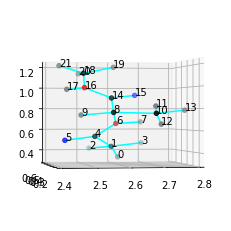

In [69]:
drawMolecule(md_traj, 0*np.pi/180, -100*np.pi/180, showIndexes=True)

In [70]:
phi_indeces, phi_0=md.compute_phi(md_traj)
psi_indeces, psi_0=md.compute_psi(md_traj)
phi_indeces=phi_indeces[0]; psi_indeces=psi_indeces[0]
psi_0=psi_0[0][0]; phi_0=phi_0[0][0]

### Adding torsion force

In [71]:
## add harmonic biasing potentials on two dihedrals of dialanine (psi, phi) in the
#OpenMM system
## for dihedral phi
bias_torsion_phi = mm.CustomTorsionForce("0.5*k_phi*dtheta^2; dtheta = min(tmp, 2*pi-tmp); tmp = abs(theta - phi)")
bias_torsion_phi.addGlobalParameter("pi", np.pi)
bias_torsion_phi.addGlobalParameter("k_phi", 131)
bias_torsion_phi.addGlobalParameter("phi", float(phi_0))
e, f, g, k = phi_indeces
bias_torsion_phi.addTorsion(int(e), int(f), int(g), int(k))

## for dihedral psi
bias_torsion_psi = mm.CustomTorsionForce("0.5*k_psi*dtheta^2; dtheta = min(tmp, 2*pi-tmp); tmp = abs(theta - psi)")
bias_torsion_psi.addGlobalParameter("pi", np.pi)
bias_torsion_psi.addGlobalParameter("k_psi", 131)
bias_torsion_psi.addGlobalParameter("psi", float(psi_0))
e, f, g, k = psi_indeces
bias_torsion_psi.addTorsion(int(e), int(f), int(g), int(k))

0

In [72]:
#add the torsion to the system
system.addForce(bias_torsion_psi)
system.addForce(bias_torsion_phi)

6

### Adding the rest

In [73]:
integrator = mm.LangevinIntegrator(temperature , friction , timestep)
integrator.setConstraintTolerance(1e-7)

platform = mm.Platform.getPlatformByName("OpenCL")
platform_properties = {"DeviceIndex": "0", "Precision": "mixed"}

## Creating simulaiton

In [74]:
simulation = mm.app.Simulation(topology, system, integrator, platform, platform_properties)

#setting positions and velocities
simulation.context.setPositions(positions)
simulation.context.setVelocitiesToTemperature(temperature)

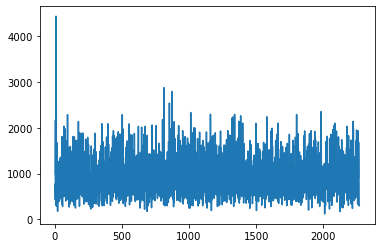

In [75]:
#computing forces
forces=simulation.context.getState(getForces=True).getForces(asNumpy=True)
forces_total=np.sqrt(forces[:,0]**2+forces[:,1]**2+forces[:,2]**2)
n=np.arange(len(forces_total))
plt.plot(n,forces_total)

### Putting reporters

In [76]:
simulation.reporters.append(app.DCDReporter('{}/{}-run-{}.dcd'.format(resultsdir, name, run), 5000))
simulation.reporters.append(app.StateDataReporter('{}/{}-scalars-{}.csv'.format(resultsdir, name, run), 
    1000, time=True, potentialEnergy=True, totalEnergy=True,
    temperature=True, speed=True, elapsedTime=True))

In [77]:
#setting the list of atoms to save
atom_list = []
for residue in topology.residues():
    if residue.name != 'HOH':
        print(residue.name)
        for atom in residue.atoms():
            atom_list.append(atom.index)

ACE
ALA
NME


## Running Simulation

In [78]:
last_chk=0

In [79]:
# How frequently to save
step_size = 100
# How many steps that are saved
n_steps = 2
# How many times to save
loops = 100
#How long to equilibrate
equil_steps=1000
#Total window time
equil_time=equil_steps*timestep.in_units_of(unit.picosecond)
window_time=timestep.in_units_of(unit.picosecond)*step_size*n_steps*loops+equil_time

In [80]:
print(f"Simulation time per sampling: {window_time} \n({window_time-equil_time} of production time + {equil_time} of equilibration time)")

Simulation time per sampling: 42.0 ps 
(40.0 ps of production time + 2.0 ps of equilibration time)


In [81]:
#Computing the window ranges
n_windows=360//20; angle_step=20*np.pi/180
total_windows=n_windows*n_windows
psi=np.array([psi_0+angle_step*i for i in range(n_windows)])%(2*np.pi)
phi=np.array([phi_0+angle_step*i for i in range(n_windows)])%(2*np.pi)

In [82]:
print(f"Simulation time total: {total_windows*window_time.in_units_of(unit.nanosecond)}")

Simulation time total: 13.607999999999997 ns


In [83]:
for idx in range(total_windows):
    psi_index=idx%n_windows
    phi_index=idx//n_windows
    
    print(f"Sampling at psi index: {psi_index} out of {n_windows}, \n         at phi index: {phi_index} out of {n_windows}")
    
    #setting parameters of the biasing potential
    simulation.context.setParameter("psi", psi[psi_index])
    simulation.context.setParameter("phi", phi[phi_index])
    
    ## minimizing
    simulation.minimizeEnergy()
    print("Energy minimized")
    
    #relaxing system
    simulation.step(equil_steps)
    
    for loop in range(last_chk,loops):
        forces_list = []
        position_list = []
        energies = []
        for ix in range(n_steps):
            forces_list.append([])
            position_list.append([])
            forces = simulation.context.getState(getForces=True).getForces(asNumpy=True)[atom_list]
            forces = forces.value_in_unit(unit.kilocalorie_per_mole/unit.angstrom)
            position = simulation.context.getState(getPositions=True,enforcePeriodicBox=True).getPositions(asNumpy=True)[atom_list]
            position = position.value_in_unit(unit.angstrom)
            energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
            energy = energy.value_in_unit(unit.kilocalorie_per_mole)

            forces_list[-1].append(forces)
            position_list[-1].append(position)
            energies.append(energy)
            simulation.step(step_size)
            percentageBar=percentageString((ix+(loop*n_steps)),(n_steps*loops-1),50)
            print("\rSimulating: {:.06f}%  {}".format((ix+(loop*n_steps))/(n_steps*loops)*100,percentageBar), end="")

        with open('{}/{}-phi-{}-psi-{}-loop-{}-checkpoint.chk'.format(resultsdir,name, phi_index, psi_index, loop), 'wb') as f:
            f.write(simulation.context.createCheckpoint())

        forces = np.concatenate(forces_list,axis=0)
        positions = np.concatenate(position_list,axis=0)
        np.save('{}/{}-phi-{}-psi-{}-loop-{}-forces.npy'.format(resultsdir,name, phi_index, psi_index, loop),forces)
        np.save('{}/{}-phi-{}-psi-{}-loop-{}-coords.npy'.format(resultsdir,name, phi_index, psi_index, loop),positions)
        np.save('{}/{}-phi-{}-psi-{}-loop-{}-energy.npy'.format(resultsdir,name, phi_index, psi_index, loop),energies)
    crd = simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions()
    pdb.writeFile(topology, crd, open(resultsdir+'/{}-phi-{}-psi{}-run-{}.pdb'.format(name,phi_index, psi_index, run), 'w'))


Sampling at psi index: 0 out of 18, 
         at phi index: 0 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 1 out of 18, 
         at phi index: 0 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 2 out of 18, 
         at phi index: 0 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 3 out of 18, 
         at phi index: 0 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 4 out of 18, 
         at phi index: 0 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 5 out of 18, 
         at phi index: 0 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Samp

Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 14 out of 18, 
         at phi index: 2 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 15 out of 18, 
         at phi index: 2 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 16 out of 18, 
         at phi index: 2 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 17 out of 18, 
         at phi index: 2 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 0 out of 18, 
         at phi index: 3 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 1 out of 18, 
         at phi index: 3 out of 18


Simulating: 99.500000%  [==================================================X]Sampling at psi index: 4 out of 18, 
         at phi index: 8 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 5 out of 18, 
         at phi index: 8 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 6 out of 18, 
         at phi index: 8 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 7 out of 18, 
         at phi index: 8 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 8 out of 18, 
         at phi index: 8 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 9 out of 18, 
         at phi index: 8 out of 18
Energy minimized
Simu

Simulating: 99.500000%  [==================================================X]Sampling at psi index: 12 out of 18, 
         at phi index: 13 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 13 out of 18, 
         at phi index: 13 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 14 out of 18, 
         at phi index: 13 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 15 out of 18, 
         at phi index: 13 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 16 out of 18, 
         at phi index: 13 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 17 out of 18, 
         at phi index: 13 out of 18
Energy mi

Simulating: 99.500000%  [==================================================X]Sampling at psi index: 7 out of 18, 
         at phi index: 16 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 8 out of 18, 
         at phi index: 16 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 9 out of 18, 
         at phi index: 16 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 10 out of 18, 
         at phi index: 16 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 11 out of 18, 
         at phi index: 16 out of 18
Energy minimized
Simulating: 99.500000%  [==================================================X]Sampling at psi index: 12 out of 18, 
         at phi index: 16 out of 18
Energy minim

In [ ]:
#Save the bias potential base angles
np.save('{}/{}-psi-bias.npy'.format(resultsdir,name),psi)
np.save('{}/{}-phi-bias.npy'.format(resultsdir,name),phi)

In [ ]:
crd = simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions()
pdb.writeFile(topology, crd, open(resultsdir+'/{}-run-{}.pdb'.format(name,run), 'w'))


In [ ]:
with open('{}/{}-{}-checkpoint.chk'.format(resultsdir,name, last_chk), 'rb') as f:
        simulation.context.loadCheckpoint(f.read())